In [68]:
import numpy as  np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from syn_gyn_module import *
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,.3f}'.format



# Generate example data

In [69]:
# Unit
num_units = 300

# Time
num_timesteps = 300

# Metrics
metric1 = Metric("sales", metric_range = [0,100000] )
metrics = [metric1]

# Interventions: control(ad 0), (ad 1), (ad 2)
num_interventions = 3


# unit covariates: location and size
loc = UnitCov("location", categories= ["New York", "LA", "Boston"])
size = UnitCov("size", categories= ["small", "medium", "large"])
unit_cov = [loc, size]

# intervention covariates: 
# Note that the assignments here makes the association between ad 0 and intervention 00, ad 1 and intervention 1, etc ..
treatment = IntCov("ads", discrete = True, categories= ["ad 0","ad 1","ad 2"], divisions = 3, assignment= [0,1,2])
int_cov = [treatment]

# initalize and generate
data = SyntheticDataModule(num_units, num_timesteps, num_interventions, metrics, unit_cov, int_cov , freq = "1D")

# generate initial data
data.generate()



In [70]:
# Now we will define differen subpopulations andd specific effects on them for each intervention

# choose sub populations of interest where interventions will have different effects
subpop1 = lambda :loc.unit_labels == 'New York'
subpop2 = lambda :loc.unit_labels == 'Boston'
subpop3 = lambda :loc.unit_labels == 'LA'
data.subpopulations_funcs = [subpop1, subpop2, subpop3]

# (this is just for keeping records, and for things we needed in profeci. Now it is only needed for export below)
data.subpopulations = [{"name":'subpop1',"id":0, "conditions": [{"column": loc.name, "level" : 0, "type":"categorical", "values": ["New York"]}]}, 
{"name":'subpop2', "id":1, "conditions": [{"column": loc.name, "level" : 0, "type":"categorical", "values": ["Boston"]}]},
{"name":'subpop3', "id":2, "conditions": [{"column": loc.name, "level" : 0, "type":"categorical", "values": ["LA"]}]}]

# We will assume that intervention 1 will incure an in crease of 30% in sales for some subpop, and 2 will incure a drop of 30% in sales for all subpops
effects = [
   {"metric": metric1, "intervention": 1, "subpop": subpop1, "effect": 0.3},
   {"metric": metric1, "intervention": 1, "subpop": subpop2, "effect": 0.0},
   {"metric": metric1, "intervention": 1, "subpop": subpop3, "effect": 0.3}, 
   {"metric": metric1, "intervention": 2, "subpop": None, "effect": -0.4}, 
        ]

data.add_effects(effects)



In [71]:
# How to assign interventions? I.e., how to subsample the tensor?
# you do that by definine sequential periods, each period will to choose two things:
    # intervention_assignment: must be one of:
            #  random: completely at random
            #  random_unit: random for each unit (but constant in time)
            #  cov_unit: based on a covariate of the unit (could be randomized)
            #  or control: use control
    # unitl (integer): use this assignment from the last assigned point until this point in time.
# control example
period_1 =  {"intervention_assignment": "control", "until": 100}

# cov_unit example
# cov unit also need "assignment_subpop" policy which is a dictionary of subpopulations (keys) and probability of assignment (list of float in [0,1] that must be of length (num_interventions) and must sum to one)
intervention_assignment = "cov_unit"
selection_subpop = {subpop1 : [0.3,0.3,0.4], subpop2 : [0.30,0.30,0.4], subpop3: [0.2, 0.4, 0.4] }
period_2 = {"intervention_assignment": intervention_assignment, "until": num_timesteps, "assignment_subpop": selection_subpop}

periods = [period_1, period_2]

data.auto_subsample(periods)


## see data

In [72]:
data.ss_df

,unit_id,time,location,size,intervention,sales,ads
0,0,2020-01-01,New York,small,0,"83,639.786",ad 0
1,0,2020-01-02,New York,small,0,"41,752.057",ad 0
2,0,2020-01-03,New York,small,0,"48,365.933",ad 0
3,0,2020-01-04,New York,small,0,"41,660.406",ad 0
4,0,2020-01-05,New York,small,0,"50,185.031",ad 0
...,...,...,...,...,...,...,...
89995,299,2020-10-22,LA,medium,2,"25,850.401",ad 2
89996,299,2020-10-23,LA,medium,2,"26,910.385",ad 2
89997,299,2020-10-24,LA,medium,2,"29,433.810",ad 2
89998,299,2020-10-25,LA,medium,2,"29,087.017",ad 2


### plot data from full tensor for unit 0 at different interventions

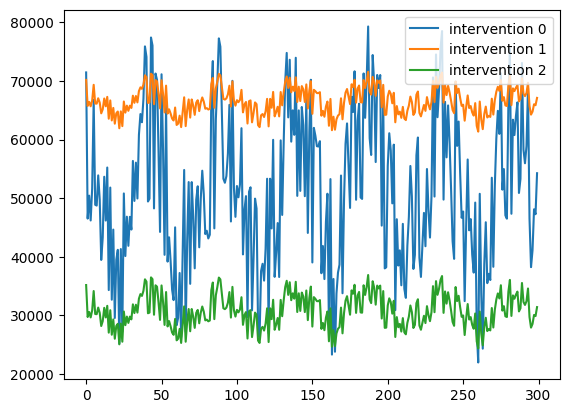

In [73]:
unit = np.argmax(loc.unit_labels == "LA")

plt.plot(data.tensor[unit,:,0,], label = "intervention 0")
plt.plot(data.tensor[unit,:,1,], label = "intervention 1")
plt.plot(data.tensor[unit,:,2,], label = "intervention 2")
plt.legend()
plt.show()

### plot for a unit that should not be affected by intervention 1 

In [74]:
unit = np.argmax(loc.unit_labels == "Boston")
unit

7

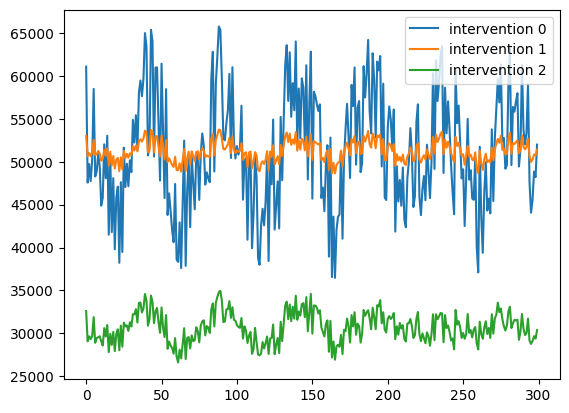

In [75]:
plt.plot(data.tensor[unit,:,0,], label = "intervention 0")
plt.plot(data.tensor[unit,:,1,], label = "intervention 1")
plt.plot(data.tensor[unit,:,2,], label = "intervention 2")
plt.legend()
plt.show()

# export data

In [41]:
data.export("store_sales_simple_2", dir = "../data/")